In [1]:
import time
from collections import OrderedDict
from pathlib import Path

import torch
from lib.structures.field_list import collect

from lib import utils, logger, config, modeling, solver, data

%load_ext autoreload
%autoreload 2

## Setup

In [2]:
config.merge_from_file('configs/front3d_train_3d.yaml')

model = modeling.PanopticReconstruction()
device = torch.device(config.MODEL.DEVICE)
model.to(device, non_blocking=True)

model.log_model_info()
model.fix_weights()

# Setup optimizer, scheduler, checkpointer
optimizer = torch.optim.Adam(model.parameters(), config.SOLVER.BASE_LR,
                                          betas=(config.SOLVER.BETA_1, config.SOLVER.BETA_2),
                                          weight_decay=config.SOLVER.WEIGHT_DECAY)
scheduler = solver.WarmupMultiStepLR(optimizer, config.SOLVER.STEPS, config.SOLVER.GAMMA,
                                                  warmup_factor=1,
                                                  warmup_iters=0,
                                                  warmup_method="linear")


-----------------------------------------
unet_output_channels 16
unet_fetures 16


In [3]:
model_dict = model.state_dict()
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of Trainable Parameters: {}".format(pytorch_total_params))

output_path = Path('output')
checkpointer = utils.DetectronCheckpointer(model, optimizer, scheduler, output_path)

# Load the checkpoint
checkpoint_data = checkpointer.load()

checkpoint_arguments = {}
checkpoint_arguments["iteration"] = 0

if config.SOLVER.LOAD_SCHEDULER:
    checkpoint_arguments.update(checkpoint_data)

# TODO: move to checkpointer?
if config.MODEL.PRETRAIN2D:
    pretrain_2d = torch.load(config.MODEL.PRETRAIN2D)
    model.load_state_dict(pretrain_2d["model"])
    
# Dataloader
dataloader = data.setup_dataloader(config.DATASETS.TRAIN)

Number of Trainable Parameters: 10367060
Number of Trainable Parameters: 10367060


## Training

In [6]:
# Switch training mode
# self.model.switch_training()
print(len(dataloader))
model.switch_training()
iteration = 0
iteration_end = time.time()


for idx, (image_ids, targets) in enumerate(dataloader):
    assert targets is not None, "error during data loading"
    data_time = time.time() - iteration_end
    # Get input images
    images = collect(targets, "color")

    # Pass through model
    # try:
    losses, results = model(images, targets)
    # except Exception as e:
    #     print(e, "skipping", image_ids[0])
    #     del targets, images
    #     continue
    
    # Accumulate total loss
    total_loss: torch.Tensor = 0.0
    log_meters = OrderedDict()

    for loss_group in losses.values():
        for loss_name, loss in loss_group.items():
            if torch.is_tensor(loss) and not torch.isnan(loss) and not torch.isinf(loss):
                total_loss += loss
                log_meters[loss_name] = loss.item()

    # Loss backpropagation, optimizer & scheduler step
    optimizer.zero_grad()

    if torch.is_tensor(total_loss):
        total_loss.backward()
        optimizer.step()
        scheduler.step()
        log_meters["total"] = total_loss.item()
    else:
        log_meters["total"] = total_loss

    # Minkowski Engine recommendation
    torch.cuda.empty_cache()
    
    # Save checkpoint
    if iteration % config.SOLVER.CHECKPOINT_PERIOD == 0:
        checkpointer.save(f"model_{iteration:07d}", **checkpoint_arguments)
    
    last_training_stage = model.set_current_training_stage(iteration)
    
    # Save additional checkpoint after hierarchy level
    if last_training_stage is not None:
        checkpointer.save(f"model_{last_training_stage}_{iteration:07d}", **checkpoint_arguments)
        logger.info(f"Finish {last_training_stage} hierarchy level")
    
    iteration += 1
    iteration_end = time.time()

    print("\riteration: {}, total_loss: {}".format(iteration, total_loss), end="")
    if iteration%10 == 0:
        print("\riteration: {}, total_loss: {}".format(iteration, total_loss))
        
    # if idx>4:
        # break


300
aux_views torch.Size([1, 4, 3, 240, 320])
cam_poses torch.Size([1, 4, 1, 4, 4])
dict_keys(['geometry', 'instance3d', 'instance3d_prediction', 'semantic3d', 'semantic3d_label'])

geometry_sparse shape:  torch.Size([156838, 1])
rgb_sparse shape:  torch.Size([156838, 3])

geometry_dense shape:  torch.Size([256, 256, 256])
rgb_dense shape:  torch.Size([3, 256, 256, 256])


RuntimeError: CUDA out of memory. Tried to allocate 2.25 GiB (GPU 0; 14.76 GiB total capacity; 11.38 GiB already allocated; 1.77 GiB free; 11.42 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## Get color prediction for rendering

In [5]:
print(results.keys())
print(results['frustum'].keys())
geometry_sparse_prediction = results['frustum']['geometry']
rgb_sparse_prediction = results['frustum']['rgb']
print("geometry_sparse shape: ", geometry_sparse_prediction.shape)
print("rgb_sparse shape: ", rgb_sparse_prediction.shape)

dict_keys(['depth', 'instance', 'projection', 'frustum'])
dict_keys(['occupancy_64', 'instance3d_64', 'semantic3d_64', 'occupancy_128', 'instance3d_128', 'semantic3d_128', 'occupancy_256', 'geometry', 'instance3d', 'instance3d_prediction', 'semantic3d', 'semantic3d_label', 'rgb'])
geometry_sparse shape:  torch.Size([102703, 1])
rgb_sparse shape:  torch.Size([102703, 3])


In [6]:
from lib.structures import DepthMap
import numpy as np
from typing import Tuple
from lib.structures.frustum import compute_camera2frustum_transform

color_image_size = (320, 240)

dense_dimensions = torch.Size([1, 1] + config.MODEL.FRUSTUM3D.GRID_DIMENSIONS)
min_coordinates = torch.IntTensor([0, 0, 0]).to(device)
truncation = config.MODEL.FRUSTUM3D.TRUNCATION

# Get Dense Predictions
geometry, _, _ = geometry_sparse_prediction.dense(dense_dimensions, min_coordinates, default_value=truncation)
rgb, _, _ = rgb_sparse_prediction.dense(dense_dimensions, min_coordinates)
geometry = geometry.squeeze()
rgb = rgb.squeeze()
print("input shape: ", images.shape)
print("rgb: {}".format(rgb.shape))
print("rgb values: [{},{}]".format(torch.max(rgb), torch.min(rgb)))
print("geometry: {}".format(geometry.shape))
print("geometry values: [{},{}]".format(torch.max(geometry), torch.min(geometry)))

input shape:  torch.Size([1, 3, 240, 320])
rgb: torch.Size([3, 256, 256, 256])
rgb values: [3.7180960178375244,0.0]
geometry: torch.Size([256, 256, 256])
geometry values: [3.0,0.0]


## Use marching cubes to generate mesh

In [7]:
import marching_cubes as mc

distance_field = geometry.clone()
colors = rgb.clone().permute(1,2,3,0)

if isinstance(distance_field, torch.Tensor):
    distance_field = distance_field.detach().cpu().numpy()
if isinstance(colors, torch.Tensor):
    colors = colors.detach().cpu().numpy()
    
vertices_i, triangles_i = mc.marching_cubes_color(distance_field, colors, 1.0, truncation)
colors_i = vertices_i[..., 3:]
vertices_i = vertices_i[..., :3]

vertices = torch.from_numpy(vertices_i.astype(np.float32))
triangles = torch.from_numpy(triangles_i.astype(np.int64))
colors_rgb = torch.from_numpy(colors_i.astype(np.float32)).unsqueeze(0)

print("vertices shape: {}".format(vertices.shape))
print("vertices range: [{},{}]".format(torch.max(vertices), torch.min(vertices)))

print("colors shape: {}".format(colors_rgb.shape))
print("triangles shape: {}".format(triangles.shape))

vertices shape: torch.Size([42170, 3])
vertices range: [186.60873413085938,76.24443054199219]
colors shape: torch.Size([1, 42170, 3])
triangles shape: torch.Size([84432, 3])


In [9]:
# from pytorch3d.ops import cubify
# meshes = cubify(geometry.unsqueeze(0), thresh=1.0)
# print(type(meshes[0]))
from torchmcubes import marching_cubes, grid_interp
vertices, faces = marching_cubes(geometry, 1.0)
colors = grid_interp(rgb, vertices)

In [11]:
# colors = torch.randn_like(vertices)
# colors = colors-torch.min(colors)
# colors = colors/torch.max(colors)
print("vertices shape: ", vertices.shape)
print("vertices range: [{}, {}]".format(torch.max(vertices), torch.min(vertices)))
print("faces shape: ", faces.shape)
print("colors shape: ", colors.shape)
print("colors range: [{}, {}] ".format(torch.max(colors), torch.min(colors)))

vertices shape:  torch.Size([253272, 3])
vertices range: [186.60873413085938, 76.24443054199219]
faces shape:  torch.Size([84424, 3])
colors shape:  torch.Size([253272, 3])
colors range: [3.30059814453125, 0.0] 


## Render Views

In [12]:
import os
import sys
import torch
import pytorch3d
# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj, load_ply

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import Textures

from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    look_at_rotation,
    FoVPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    HardPhongShader,
    SoftPhongShader,
    TexturesUV,
    TexturesVertex,
    OpenGLPerspectiveCameras, 
    PerspectiveCameras
    
)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Generate texture
# tex = Textures(verts_rgb=colors_rgb)
# mesh = Meshes(verts=[vertices], faces=[triangles], textures=tex).to(device)

tex = Textures(verts_rgb=colors.unsqueeze(0))
mesh = Meshes(verts=[vertices], faces=[faces], textures=tex).to(device)

# We scale normalize and center the target mesh 

verts = mesh.verts_packed()
N = verts.shape[0]
center = verts.mean(0)
scale = 1/42.4
center = torch.from_numpy(np.float32([3.0, 3.0, 3.0])).to(device)/float(scale)
mesh.offset_verts_(-center)
mesh.scale_verts_((-1.0 * float(scale)))

print("verts range: [{},{}]".format(torch.min(mesh.verts_packed()),torch.max(mesh.verts_packed())))
# center = mesh.verts_packed().mean(0)
center *= -scale
print("center = ", center)

verts range: [-1.4011495113372803,1.2017822265625]
center =  tensor([-3., -3., -3.], device='cuda:0')


### Get image transformations

In [29]:
def homogeneous_transform(R,t):
    last_row = torch.FloatTensor([[0,0,0,1]]).unsqueeze(0)
    T = torch.cat((R,t),dim=2)
    return torch.cat((T,last_row),dim=1)

color_image_size = (240, 320)
FOCAL_LENGTH1 = 277.1281435
FOCAL_LENGTH2 = 311.76912635
DEPTH_MIN = 0.4
DEPTH_MAX = 6.0
# fov_x = camera_pose['fov_x']
# fov_y = camera_pose['fov_y']

# Base transform (Original transform to render images in the view frustum)
R0, t0 = look_at_view_transform(dist = 2.5, elev=0, azim=90)
T_C1W = homogeneous_transform(R0,t0.transpose(0,1).unsqueeze(0))
print("\T_C1W: ", T_C1W)

# Ground truth camera pose in the dataset
cam2world = np.load('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/campose_0001.npz')['camera2world']
print("cam2world", cam2world.shape)
t1 = cam2world[:-1,-1]
R1 = cam2world[:3,:3]
t1 = torch.from_numpy(t1).type(torch.FloatTensor).unsqueeze(0)
R1 = torch.from_numpy(R1).type(torch.FloatTensor).unsqueeze(0)
T_GC1 = homogeneous_transform(R1,t1.transpose(0,1).unsqueeze(0))
print("\nT_GC1: ", T_GC1)

# Auxiliary views:
# View 1
cam2world = np.load('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/campose_0005.npz')['camera2world']
t2 = cam2world[:-1,-1]
R2 = cam2world[:3,:3]
t2 = torch.from_numpy(t2).type(torch.FloatTensor).unsqueeze(0)
R2 = torch.from_numpy(R2).type(torch.FloatTensor).unsqueeze(0)
T_GC2 = homogeneous_transform(R2,t2.transpose(0,1).unsqueeze(0))
print("\nT_GC2: ", T_GC2 )

# Compute transform to auxiliary view
T_C2W=torch.zeros_like(T_C1W) 
T_C2W[0] = torch.inverse(T_GC2[0]) @ T_GC1[0] @ T_C1W
print("T_C2W: ", T_C2W )

# View 2
cam2world = np.load('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/campose_0018.npz')['camera2world']
t3 = cam2world[:-1,-1]
R3 = cam2world[:3,:3]
t3 = torch.from_numpy(t3).type(torch.FloatTensor).unsqueeze(0)
R3 = torch.from_numpy(R3).type(torch.FloatTensor).unsqueeze(0)
T_GC3 = homogeneous_transform(R3,t3.transpose(0,1).unsqueeze(0))
print("\nT_GC3: ", T_GC3 )

# Compute transform to auxiliary view
T_C3W=torch.zeros_like(T_C1W) 
T_C3W[0] = torch.inverse(T_GC3[0]) @ T_GC1[0] @ T_C1W
print("T_C3W: ", T_C3W )

# View 2
cam2world = np.load('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/campose_0021.npz')['camera2world']
t4 = cam2world[:-1,-1]
R4 = cam2world[:3,:3]
t4 = torch.from_numpy(t4).type(torch.FloatTensor).unsqueeze(0)
R4 = torch.from_numpy(R4).type(torch.FloatTensor).unsqueeze(0)
T_GC4 = homogeneous_transform(R4,t4.transpose(0,1).unsqueeze(0))
print("\nT_GC4: ", T_GC4 )

# Compute transform to auxiliary view
T_C4W=torch.zeros_like(T_C1W) 
T_C4W[0] = torch.inverse(T_GC4[0]) @ T_GC1[0] @ T_C1W
print("T_C4W: ", T_C4W )

# Rasterizer
raster_settings = RasterizationSettings(
    image_size=color_image_size, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])


\T_C1W:  tensor([[[ 4.3711e-08,  0.0000e+00, -1.0000e+00, -0.0000e+00],
         [-0.0000e+00,  1.0000e+00,  0.0000e+00, -0.0000e+00],
         [ 1.0000e+00,  0.0000e+00,  4.3711e-08,  2.5000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]])
cam2world (4, 4)

T_GC1:  tensor([[[ 8.9057e-01, -2.8493e-06,  4.5484e-01, -3.5470e+00],
         [-4.5484e-01, -5.5901e-06,  8.9057e-01,  2.6655e+00],
         [ 5.1204e-09, -1.0000e+00, -6.2744e-06,  7.5000e-01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]])

T_GC2:  tensor([[[ 9.1425e-01, -2.5458e-06,  4.0515e-01, -2.7242e+00],
         [-4.0515e-01, -5.7347e-06,  9.1425e-01,  3.1131e+00],
         [-4.0992e-09, -1.0000e+00, -6.2744e-06,  7.5000e-01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]])
T_C2W:  tensor([[[ 5.5023e-02, -3.3602e-07, -9.9849e-01, -4.3333e-01],
         [ 9.2796e-09,  1.0000e+00, -3.3602e-07,  4.6724e-06],
         [ 9.9849e-01,  9.2227e-09,  5.5023e-02,  1.7537e+00

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


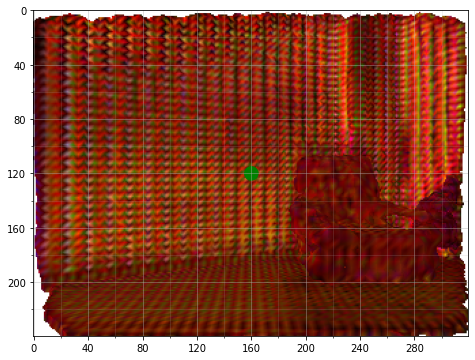

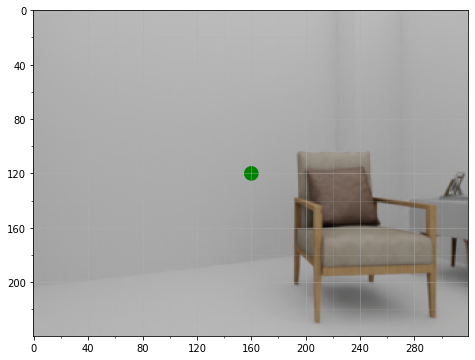

In [30]:
from plot_image_grid import plot_image
from PIL import Image
T_WC = T_C1W.clone()
# print(T_WC.shape)
# T_WC[0][0][3] = -0.1

cameras = PerspectiveCameras(device=device, R=T_WC[:,:3,:3], T=T_WC[:,:3,-1], focal_length=((FOCAL_LENGTH1,FOCAL_LENGTH1),),
                             principal_point=(([160,120]),), image_size=((240, 320), ),in_ndc=False) #, K=front3d_intrinsic.unsqueeze(0))\

renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

images = renderer(mesh)
plot_image(images[0, ..., :3].cpu().numpy())

input_img = Image.open('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/rgb_0001.png')
plot_image(input_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


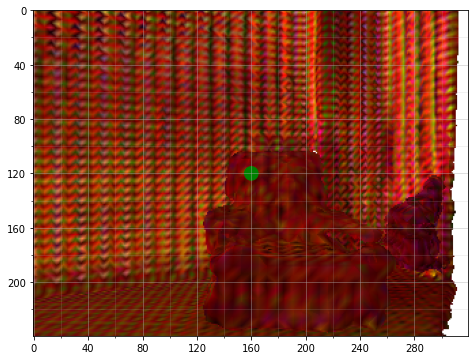

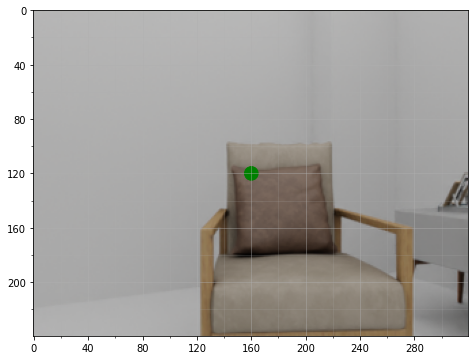

In [32]:
T_WC = T_C2W.clone()
# print(T_WC.shape)
T_WC[0][0][3] += 0.75
T_WC[0][2][3] += 0.33

cameras = PerspectiveCameras(device=device, R=T_WC[:,:3,:3], T=T_WC[:,:3,-1], focal_length=((FOCAL_LENGTH1,FOCAL_LENGTH1),),
                             principal_point=(([160,120]),), image_size=((240, 320), ),in_ndc=False) #, K=front3d_intrinsic.unsqueeze(0))\

renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

images = renderer(mesh)
plot_image(images[0, ..., :3].cpu().numpy())

input_img = Image.open('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/rgb_0005.png')
plot_image(input_img)

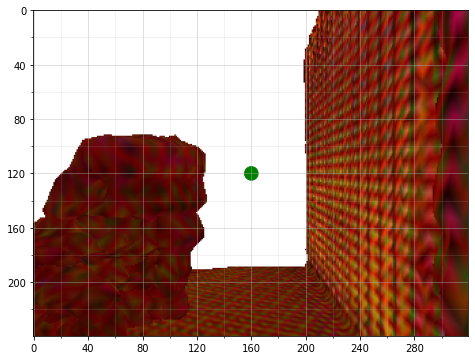

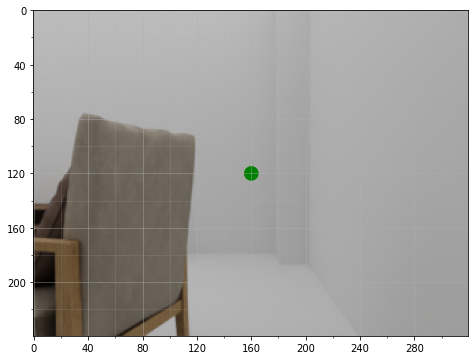

In [56]:
T_WC = T_C4W.clone()
# print(T_WC.shape)
T_WC[0][0][3] -= 0.25
T_WC[0][2][3] -= 0.51

cameras = PerspectiveCameras(device=device, R=T_WC[:,:3,:3], T=T_WC[:,:3,-1], focal_length=((FOCAL_LENGTH1,FOCAL_LENGTH1),),
                             principal_point=(([160,120]),), image_size=((240, 320), ),in_ndc=False) #, K=front3d_intrinsic.unsqueeze(0))\

renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

images = renderer(mesh)
plot_image(images[0, ..., :3].cpu().numpy())

input_img = Image.open('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/rgb_0021.png')
plot_image(input_img)

In [ ]:
T_WC = T_C4W.clone()
# print(T_WC.shape)
T_WC[0][0][3] += 0.60
T_WC[0][2][3] += 0.35

cameras = PerspectiveCameras(device=device, R=T_WC[:,:3,:3], T=T_WC[:,:3,-1], focal_length=((FOCAL_LENGTH1,FOCAL_LENGTH1),),
                             principal_point=(([160,120]),), image_size=((240, 320), ),in_ndc=False) #, K=front3d_intrinsic.unsqueeze(0))\

renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

images = renderer(mesh)
plot_image(images[0, ..., :3].cpu().numpy())

input_img = Image.open('data/front3d/70f7c6c1-c48f-4106-bcef-40b80b84bbad/rgb_0018.png')
plot_image(input_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[ 4.3711e-08,  0.0000e+00, -1.0000e+00],
         [-0.0000e+00,  1.0000e+00,  0.0000e+00],
         [ 1.0000e+00,  0.0000e+00,  4.3711e-08]]])
tensor([[-0.0000, -0.0000, 3.2000]])


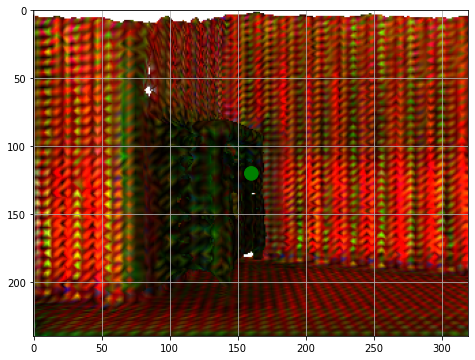

In [1627]:
# Initialize a camera.

# With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction. 
# So we move the camera by 180 in the azimuth direction so it is facing the front of the cow. 

# R, T = look_at_view_transform(2.0, 10, 150.0) 
# print(T)
# R0 = look_at_rotation(T, at=((0, 0, 3.0), ), up=((0, -1, 0), ))
# print(R)

# R, T = look_at_view_transform(eye=((3.0, 0.0, -0.0),), at=((0.0, 0.0, 0.0), ), up=((0, 1, 0), ))  #(in/out, ver, hor)
# R, T = look_at_view_transform(eye= ((4.0, 0.5, 0.55), ), at=((0.0, 0.0, -0.0), ), up=((0, 1, 0), ))

# R, T = look_at_view_transform(eye= T_gt.unsqueeze(0), at=((1.2, 0.2, 0), ), up=((0, 1, 0), ))

# R0 = look_at_rotation(T_gt.unsqueeze(0).float(), at=((0, 0, 0), ), up=((0, 1, 0), ))

R, T = look_at_view_transform(dist = 3.2, elev=0, azim=90)
# T = torch.from_numpy(np.float32([[0.0,0.0,5.0]]))
print(R)
print(T)
# T=T/2
# T[0][2]= 0.7

# pytorch3d.renderer.cameras.look_at_rotation(camera_position, at=((0, 0, 0), ), up=((0, 1, 0), ),
FOCAL_LENGTH1 = 277.1281435
FOCAL_LENGTH2 = 311.76912635

focal_length = torch.from_numpy(np.float32([FOCAL_LENGTH2,FOCAL_LENGTH1])).unsqueeze(0)
principal_point = torch.from_numpy(np.float32([160,120])).unsqueeze(0)*1.0
cameras = PerspectiveCameras(device=device, R=R, T=T, focal_length=focal_length,principal_point=principal_point, image_size=((240, 320), ),in_ndc=False) #, K=front3d_intrinsic.unsqueeze(0))
# # print(cameras.K)

# cameras = PerspectiveCameras(device=device, R=R, T=T) #, K=front3d_intrinsic.unsqueeze(0))

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=color_image_size, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
# -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Create a Phong renderer by composing a rasterizer and a shader. The textured Phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

images = renderer(mesh)
fig, ax = plt.subplots(figsize=(8, 6))
ax.grid(True)
ax.imshow(images[0, ..., :3].cpu().numpy())
circle1 = plt.Circle((160, 120), 5, color='g')
ax.add_patch(circle1)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(240, 320, 3)


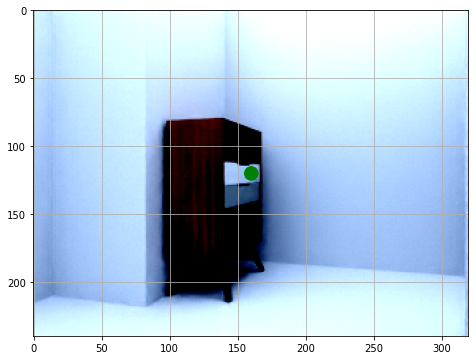

In [1622]:


# input_img = dataset[0][1].get_field("color").cpu().numpy()
# input_img = np.transpose(input_img, (1, 2, 0))
# print(input_img.shape)
# fig, ax = plt.subplots(figsize=(8, 6))
# ax.grid(which='both')
# ax.imshow(input_img)
# circle1 = plt.Circle((160, 120), 5, color='g')
# ax.add_patch(circle1)
# ax.set_xticks(major_ticks)
# ax.set_xticks(minor_ticks, minor=True)
# ax.set_yticks(major_ticks)
# ax.set_yticks(minor_ticks, minor=True)
# ax.grid(which='minor', alpha=0.2)
# ax.grid(which='major', alpha=0.5)
# plt.show()


In [ ]:
# Dataset
from lib.data import samplers, datasets, collate
from lib.utils.imports import import_file
from torch.utils import data

def build_dataset(dataset_name) -> data.Dataset:
    paths_catalog = import_file("lib.config.paths_catalog", config.PATHS_CATALOG, True)
    dataset_catalog = paths_catalog.DatasetCatalog
    print("dataset_catalog: ", dataset_catalog.get(dataset_name))
    info = dataset_catalog.get(dataset_name)
    factory = getattr(datasets, info.pop("factory"))
    info["fields"] = config.DATASETS.FIELDS

    # make dataset from factory
    dataset = factory(**info)

    return dataset

dataset = build_dataset(config.DATASETS.TRAIN)

print(len(dataset))
print(dataset[0][1].get_field("color").shape)
print(dataset[0][1].fields())

In [534]:
color_image_size = (240, 320)
K = front3d_intrinsic.unsqueeze(0).cpu().numpy()

# Multiple view rendering
from plot_image_grid import image_grid
# the number of different viewpoints from which we want to render the mesh.
num_views = 1
# Get a batch of viewing angles. 
elev = torch.linspace(140, 200, num_views)
azim = torch.linspace(250, 330, num_views)

# Place a point light in front of the object. As mentioned above, the front of 
# the cow is facing the -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Initialize an OpenGL perspective camera that represents a batch of different 
# viewing angles. All the cameras helper methods support mixed type inputs and 
# broadcasting. So we can view the camera from the a distance of dist=2.7, and 
# then specify elevation and azimuth angles for each viewpoint as tensors. 
R, T = look_at_view_transform(dist=2.5, elev=elev, azim=azim)


# R0 = look_at_rotation(T, at=((0, 0, 3.0), ), up=((0, -1, 0), ))

cameras = FoVPerspectiveCameras(device=device, R=R, T=T)


# We arbitrarily choose one particular view that will be used to visualize 
# results
camera = FoVPerspectiveCameras(device=device, R=R[None, 1, ...], 
                                  T=T[None, 1, ...]) 

# Define the settings for rasterization and shading. Here we set the output 
# image to be of size 128X128. As we are rendering images for visualization 
# purposes only we will set faces_per_pixel=1 and blur_radius=0.0. Refer to 
# rasterize_meshes.py for explanations of these parameters.  We also leave 
# bin_size and max_faces_per_bin to their default values of None, which sets 
# their values using heuristics and ensures that the faster coarse-to-fine 
# rasterization method is used.  Refer to docs/notes/renderer.md for an 
# explanation of the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=color_image_size, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
    max_faces_per_bin=50000
)

# Create a Phong renderer by composing a rasterizer and a shader. The textured 
# Phong shader will interpolate the texture uv coordinates for each vertex, 
# sample from a texture image and apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings
    ),
    shader=HardPhongShader(
        device=device, 
        cameras=camera,
        lights=lights
    )
)

# Create a batch of meshes by repeating the cow mesh and associated textures. 
# Meshes has a useful `extend` method which allows us do this very easily. 
# This also extends the textures. 
meshes = mesh.extend(num_views)

# Render the cow mesh from each viewing angle
target_images = renderer(meshes, cameras=cameras, lights=lights)

# Our multi-view cow dataset will be represented by these 2 lists of tensors,
# each of length num_views.
target_rgb = [target_images[i, ..., :3] for i in range(num_views)]
target_cameras = [FoVPerspectiveCameras(device=device, R=R[None, i, ...], 
                                           T=T[None, i, ...]) for i in range(num_views)]

import matplotlib.pyplot as plt
image_grid(target_images.cpu().numpy(), rows=4, cols=5, rgb=True, show_axes=True)
plt.show()

IndexError: index 1 is out of bounds for dimension 1 with size 1

In [941]:
def adjust_intrinsic(intrinsic: np.array, intrinsic_image_dim: Tuple, image_dim: Tuple) -> np.array:
    if intrinsic_image_dim == image_dim:
        return intrinsic

    intrinsic_return = np.copy(intrinsic)

    height_after = image_dim[1]
    height_before = intrinsic_image_dim[1]

    width_after = image_dim[0]
    width_before = intrinsic_image_dim[0]

    intrinsic_return[0, 0] *= float(width_after) / float(width_before)
    intrinsic_return[1, 1] *= float(height_after) / float(height_before)

    # account for cropping/padding here
    intrinsic_return[0, 2] *= float(width_after - 1) / float(width_before - 1)
    intrinsic_return[1, 2] *= float(height_after - 1) / float(height_before - 1)

    return intrinsic_return




# Generate Mesh and Render
# Prepare intrinsic matrix.
color_image_size = (320, 240)
depth_image_size = (160, 120)
front3d_intrinsic = np.array(config.MODEL.PROJECTION.INTRINSIC)
front3d_intrinsic = adjust_intrinsic(front3d_intrinsic, color_image_size, depth_image_size)
front3d_intrinsic = torch.from_numpy(front3d_intrinsic).to(device).float()

print('\n camera_instrinsics: \n', front3d_intrinsic)
camera2frustum = compute_camera2frustum_transform(front3d_intrinsic.cpu(), torch.tensor(images.size()) / 2.0,
                                                      config.MODEL.PROJECTION.DEPTH_MIN,
                                                      config.MODEL.PROJECTION.DEPTH_MAX,
                                                      config.MODEL.PROJECTION.VOXEL_SIZE)

camera2frustum[:3, 3] += (torch.tensor([256, 256, 256]) - torch.tensor([231, 174, 187])) / 2
frustum2camera = torch.inverse(camera2frustum)
print("frustum2camera: ", frustum2camera)


 camera_instrinsics: 
 tensor([[138.5641,   0.0000,  79.5000,   0.0000],
        [  0.0000, 138.5641,  59.5000,   0.0000],
        [  0.0000,   0.0000,   1.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   1.0000]], device='cuda:0')
frustum2camera:  tensor([[ 0.0300,  0.0000,  0.0000, -3.8175],
        [ 0.0000,  0.0300,  0.0000, -3.8064],
        [ 0.0000,  0.0000,  0.0300, -0.6350],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])


# Deprecated stuff

In [14]:
# from lib.data import samplers, datasets, collate
# from lib.utils.imports import import_file
# from torch.utils import data

# def build_dataset(dataset_name) -> data.Dataset:
#     paths_catalog = import_file("lib.config.paths_catalog", config.PATHS_CATALOG, True)
#     dataset_catalog = paths_catalog.DatasetCatalog
#     print("dataset_catalog: ", dataset_catalog.get(dataset_name))
#     info = dataset_catalog.get(dataset_name)
#     factory = getattr(datasets, info.pop("factory"))
#     info["fields"] = config.DATASETS.FIELDS

#     # make dataset from factory
#     dataset = factory(**info)

#     return dataset

# dataset = build_dataset(config.DATASETS.TRAIN)

# print(len(dataset))
# print(dataset[0][1].get_field("color").shape)
# print(dataset[0][1].fields())

In [ ]:
# color_image_size = (240, 320)

# # Multiple view rendering
# from plot_image_grid import image_grid
# # the number of different viewpoints from which we want to render the mesh.
# num_views = 20
# # Get a batch of viewing angles. 
# elev = torch.linspace(140, 200, num_views)
# azim = torch.linspace(250, 330, num_views)

# # Place a point light in front of the object. As mentioned above, the front of 
# # the cow is facing the -z direction. 
# lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# # Initialize an OpenGL perspective camera that represents a batch of different 
# # viewing angles. All the cameras helper methods support mixed type inputs and 
# # broadcasting. So we can view the camera from the a distance of dist=2.7, and 
# # then specify elevation and azimuth angles for each viewpoint as tensors. 
# R, T = look_at_view_transform(dist=1.5, elev=elev, azim=azim)
# R0 = look_at_rotation(T, at=((0, 0, 3.0), ), up=((0, -1, 0), ))

# cameras = FoVPerspectiveCameras(device=device, R=R, T=T)


# # We arbitrarily choose one particular view that will be used to visualize 
# # results
# camera = FoVPerspectiveCameras(device=device, R=R[None, 1, ...], 
#                                   T=T[None, 1, ...]) 

# # Define the settings for rasterization and shading. Here we set the output 
# # image to be of size 128X128. As we are rendering images for visualization 
# # purposes only we will set faces_per_pixel=1 and blur_radius=0.0. Refer to 
# # rasterize_meshes.py for explanations of these parameters.  We also leave 
# # bin_size and max_faces_per_bin to their default values of None, which sets 
# # their values using heuristics and ensures that the faster coarse-to-fine 
# # rasterization method is used.  Refer to docs/notes/renderer.md for an 
# # explanation of the difference between naive and coarse-to-fine rasterization. 
# raster_settings = RasterizationSettings(
#     image_size=color_image_size, 
#     blur_radius=0.0, 
#     faces_per_pixel=1, 
# )

# # Create a Phong renderer by composing a rasterizer and a shader. The textured 
# # Phong shader will interpolate the texture uv coordinates for each vertex, 
# # sample from a texture image and apply the Phong lighting model
# renderer = MeshRenderer(
#     rasterizer=MeshRasterizer(
#         cameras=camera, 
#         raster_settings=raster_settings
#     ),
#     shader=HardPhongShader(
#         device=device, 
#         cameras=camera,
#         lights=lights
#     )
# )

# # Create a batch of meshes by repeating the cow mesh and associated textures. 
# # Meshes has a useful `extend` method which allows us do this very easily. 
# # This also extends the textures. 
# meshes = mesh.extend(num_views)

# # Render the cow mesh from each viewing angle
# target_images = renderer(meshes, cameras=cameras, lights=lights)

# # Our multi-view cow dataset will be represented by these 2 lists of tensors,
# # each of length num_views.
# target_rgb = [target_images[i, ..., :3] for i in range(num_views)]
# target_cameras = [FoVPerspectiveCameras(device=device, R=R[None, i, ...], 
#                                            T=T[None, i, ...]) for i in range(num_views)]

# import matplotlib.pyplot as plt
# image_grid(target_images.cpu().numpy(), rows=4, cols=5, rgb=True, show_axes=True)
# plt.show()

In [15]:
# # Initialize a camera.
# color_image_size = (240, 320)

# # With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction. 
# # So we move the camera by 180 in the azimuth direction so it is facing the front of the cow. 

# # R, T = look_at_view_transform(2.0, 10, 150.0) 
# # print(T)
# # R0 = look_at_rotation(T, at=((0, 0, 3.0), ), up=((0, -1, 0), ))
# # print(R)

# R, T = look_at_view_transform(dist=1.3, elev=-180, azim=85)
# # R0 = look_at_rotation(T, at=((0, 0, 3.0), ), up=((0, -1, 0), ))
# T = torch.from_numpy(np.float32([[1.0,-1.0,1.3]]))
# print(R)
# print(T)

# # pytorch3d.renderer.cameras.look_at_rotation(camera_position, at=((0, 0, 0), ), up=((0, 1, 0), ),
# cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# # Define the settings for rasterization and shading. Here we set the output image to be of size
# # 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# # and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that 
# # the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# # explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# # the difference between naive and coarse-to-fine rasterization. 
# raster_settings = RasterizationSettings(
#     image_size=color_image_size, 
#     blur_radius=0.0, 
#     faces_per_pixel=1, 
# )

# # Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
# # -z direction. 
# lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# # Create a Phong renderer by composing a rasterizer and a shader. The textured Phong shader will 
# # interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# # apply the Phong lighting model
# renderer = MeshRenderer(
#     rasterizer=MeshRasterizer(
#         cameras=cameras, 
#         raster_settings=raster_settings
#     ),
#     shader=SoftPhongShader(
#         device=device, 
#         cameras=cameras,
#         lights=lights
#     )
# )

# images = renderer(mesh)
# plt.figure(figsize=(10, 10))
# plt.grid(True)
# plt.imshow(images[0, ..., :3].cpu().numpy())
# plt.show()

In [ ]:
# # Camera model
# from math import sin, cos,pi
# def rot_x(t):
#     return torch.FloatTensor([[1,0,0],[0,cos(t),-sin(t)],[0,sin(t),cos(t)]])

# def rot_y(t):
#     return torch.FloatTensor([[cos(t), 0, sin(t)],[0,1,0],[-sin(t),0,cos(t)]])

# def rot_z(t):
#     return torch.FloatTensor([[cos(t),-sin(t),0],[sin(t),cos(t),0],[0,0,1]])